# Deep Learning Project - KK Testbench

Currently testing difference between with/without mixreg

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import make_env, Storage, orthogonal_init

import csv

### Hyperparameters
Leave unchanged between comparison runs

In [2]:
# Hyperparameters
total_steps = 5e6
num_envs = 32
num_levels = 10
num_steps = 256
num_epochs = 3
batch_size = 256
eps = .2
grad_eps = .5
value_coef = .75
entropy_coef = .01

increase = 2 # How much to augment the dataset with mixreg
alpha = 0.5 # Alpha value to use for the beta-distribution in mixreg

### Network Definition
Leave unchanged between comparison runs

In [3]:
# Network definition
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class RandomCrop(nn.Module):
    def __init__(self, size=48):
      super().__init__()
      self.size = size
    def forward(self, x):
        n, c, h, w = x.shape
        w1 = torch.randint(0, w - self.size + 1, (n,))
        h1 = torch.randint(0, h - self.size + 1, (n,))
        cropped = torch.empty((n, c, self.size, self.size), dtype=x.dtype, device=x.device)
        for i, (img, w11, h11) in enumerate(zip(x, w1, h1)):
            cropped[i][:] = img[:, h11:h11 + self.size, w11:w11 + self.size]
        return cropped

class ResidualBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, stride=1, padding=1)
    )

  def forward(self, x):
    return self.layers(x) + x

class ImpalaBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ResidualBlock(out_channels),
        ResidualBlock(out_channels)
    )

  def forward(self, x):
    return self.layers(x)

class SimpleImpalaEncoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        RandomCrop(),
        ImpalaBlock(in_channels, out_channels=16),
        ImpalaBlock(in_channels=16, out_channels=32),
        ImpalaBlock(in_channels=32, out_channels=32),
        nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1152, out_features=feature_dim),
        nn.ReLU()
    )
  
  def forward(self, x):
    return self.layers(x)

class Encoder(nn.Module):
  def __init__(self, in_channels, feature_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4), nn.ReLU(),
        nn.BatchNorm2d(num_features=32),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2), nn.ReLU(),
        nn.BatchNorm2d(num_features=64),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.BatchNorm2d(num_features=128),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1), nn.ReLU(),
        Flatten(),
        nn.Linear(in_features=1024, out_features=feature_dim), nn.ReLU()
    )
    self.apply(orthogonal_init)

  def forward(self, x):
    return self.layers(x)


class Policy(nn.Module):
  def __init__(self, encoder, feature_dim, num_actions):
    super().__init__()
    self.encoder = encoder
    self.policy = orthogonal_init(nn.Linear(feature_dim, num_actions), gain=.01)
    self.value = orthogonal_init(nn.Linear(feature_dim, 1), gain=1.)

  def act(self, x):
    with torch.no_grad():
      x = x.cuda().contiguous()
      dist, value = self.forward(x)
      action = dist.sample()
      log_prob = dist.log_prob(action)
    
    return action.cpu(), log_prob.cpu(), value.cpu()

  def forward(self, x):
    x = self.encoder(x)
    logits = self.policy(x)
    value = self.value(x).squeeze(1)
    dist = torch.distributions.Categorical(logits=logits)

    return dist, value

## Environment and training definition

In [4]:
# Change this for comparison purposes
use_mixreg  = False

# Define environment
# check the utils.py file for info on arguments
env = make_env(num_envs, num_levels=num_levels)
print('Observation space:', env.observation_space)
print('Action space:', env.action_space.n)

# Define validation environment
eval_env = make_env(num_envs, start_level=num_levels, num_levels=num_levels,env_name='starpilot')

# Define network
encoder = SimpleImpalaEncoder(3,256)
policy = Policy(encoder, 256, env.action_space.n)
policy.cuda()

# Define optimizer
# these are reasonable values but probably not optimal
optimizer = torch.optim.Adam(policy.parameters(), lr=3e-4, eps=1e-5,weight_decay = 0.01)

# Define temporary storage
# we use this to collect transitions during each iteration
storage = Storage(
    env.observation_space.shape,
    num_steps,
    num_envs
)

## Filename for checkpoints
checkpoint_file_name = 'checkpoint'
if use_mixreg:
    checkpoint_file_name += '_mixreg'
else:
    checkpoint_file_name += '_basic'
checkpoint_file_name += '.pt'

data_log_file_name = 'training_stats'
if use_mixreg:
    data_log_file_name += '_mixreg'
else:
    data_log_file_name += '_basic'
data_log_file_name += '.csv'

Observation space: Box(0.0, 1.0, (3, 64, 64), float32)
Action space: 15


## Training Loop

In [ ]:
# Run training
obs = env.reset()
v_obs = eval_env.reset()
step = 0

data_log = []
while step < total_steps:

  # Use policy to collect data for num_steps steps
  policy.eval()
  for _ in range(num_steps):
    # Use policy
    action, log_prob, value = policy.act(obs)
    
    # Take step in environment
    next_obs, reward, done, info = env.step(action)

    # Store data
    storage.store(obs, action, reward, done, info, log_prob, value)
    
    # Update current observation
    obs = next_obs

  # Add the last observation to collected data
  _, _, value = policy.act(obs)
  storage.store_last(obs, value)

  # Compute return and advantage
  storage.compute_return_advantage()

  # Optimize policy
  policy.train()
  for epoch in range(num_epochs):

    # Iterate over batches of transitions
    if use_mixreg:
        generator = storage.get_mix_generator(increase, alpha, batch_size)
    else:
        generator = storage.get_generator(batch_size)
        
    for batch in generator:
      b_obs, b_action, b_log_prob, b_value, b_returns, b_advantage = batch

      # Get current policy outputs
      new_dist, new_value = policy(b_obs)
      new_log_prob = new_dist.log_prob(b_action)

      # Clipped policy objective
      ratio = torch.exp(new_log_prob - b_log_prob)
      clipped_ratio = ratio.clamp(min=1.0 - eps,max=1.0 + eps)
      policy_reward = torch.min(ratio * b_advantage, clipped_ratio * b_advantage)
      pi_loss = -policy_reward.mean()

      # Clipped value function objective
      V_clip = b_value + (new_value-b_value).clamp(-eps,eps)
      vf_loss = torch.max((b_value - b_returns) ** 2, (V_clip - b_returns) ** 2)
      value_loss = 0.5*vf_loss.mean()

      # Entropy loss
      entropy_loss = new_dist.entropy().mean()

      # Backpropagate losses
      loss = pi_loss + value_coef * value_loss - entropy_coef * entropy_loss
      loss.backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(policy.parameters(), grad_eps)

      # Update policy
      optimizer.step()
      optimizer.zero_grad()

  ## VALIDATION ##
  # Evaluate policy
  policy.eval()
  validation_reward = []
  for _ in range(num_steps):
    # Use policy
    v_action, v_log_prob, v_value = policy.act(v_obs)

    # Take step in environment
    v_obs, v_reward, v_done, v_info = eval_env.step(v_action)
    validation_reward.append(torch.Tensor(v_reward))

  # Calculate average return
  validation_reward = torch.stack(validation_reward).sum(0).mean(0)
  ## END OF VALIDATION ##

  # Update stats
  step += num_envs * num_steps
  print(f'Step: {step}\tMean reward: {storage.get_reward()}\tMean validation reward: {validation_reward}')
  data_point = [step, storage.get_reward().item(), validation_reward.item()]
  data_log.append(data_point)
    
with open(data_log_file_name, 'w', newline='') as f:
  writer = csv.writer(f)
  writer.writerows(data_log)

print('Completed training!')
torch.save(policy.state_dict, checkpoint_file_name)

Step: 8192	Mean reward: 3.75	Mean validation reward: 9.336302757263184
Step: 16384	Mean reward: 3.90625	Mean validation reward: 5.378912925720215
Step: 24576	Mean reward: 3.84375	Mean validation reward: 5.4661970138549805
Step: 32768	Mean reward: 4.25	Mean validation reward: 5.992478370666504
Step: 40960	Mean reward: 3.65625	Mean validation reward: 5.05367374420166
Step: 49152	Mean reward: 4.53125	Mean validation reward: 4.72085428237915
Step: 57344	Mean reward: 3.34375	Mean validation reward: 4.361542701721191
Step: 65536	Mean reward: 3.375	Mean validation reward: 4.637571334838867
Step: 73728	Mean reward: 3.625	Mean validation reward: 5.608954906463623
Step: 81920	Mean reward: 3.96875	Mean validation reward: 5.128689765930176
Step: 90112	Mean reward: 4.03125	Mean validation reward: 5.3725056648254395
Step: 98304	Mean reward: 4.53125	Mean validation reward: 5.417236328125
Step: 106496	Mean reward: 4.84375	Mean validation reward: 5.71299934387207
Step: 114688	Mean reward: 4.65625	Mean 

Step: 901120	Mean reward: 7.53125	Mean validation reward: 4.413059234619141


### Vizualize training results

Extraction:

In [9]:
import matplotlib.pyplot as plt
csv_files = [
  "training_stats_basic.csv",
  "training_stats_mixreg.csv"
  ]

full_data = []

for file in csv_files:
  data = {}
  data['x'] = []
  data['y_train'] = []
  data['y_val'] = []

  with open(file, newline='') as f:
    reader = csv.reader(f)
    for row in reader:
      data['x'].append(int(row[0]))
      data['y_train'].append(float(row[1]))
      data['y_val'].append(float(row[2]))

  full_data.append(data)

Plotting:

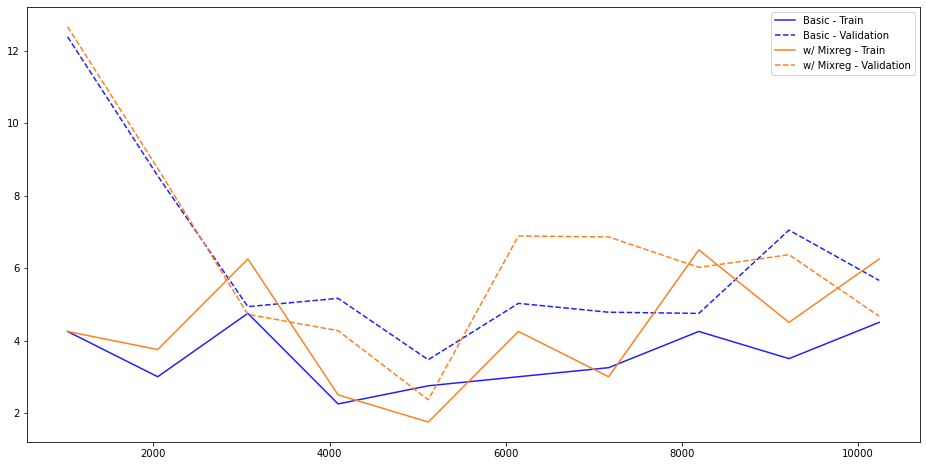

In [20]:
plt.figure(figsize=(16,8))
colors = ["#2020FF","#FF8020"]
for i, data in enumerate(full_data):
  plt.plot(data['x'], data['y_train'], linestyle="-", color=colors[i],)
  plt.plot(data['x'], data['y_val'], linestyle="--", color=colors[i])

plt.legend(["Basic - Train","Basic - Validation","w/ Mixreg - Train","w/ Mixreg - Validation"])



plt.show()

In [21]:
import imageio

# Make evaluation environment
eval_env = make_env(num_envs, start_level=num_levels, num_levels=num_levels,env_name='starpilot')
obs = eval_env.reset()

frames = []
total_reward = []

# Evaluate policy
policy.eval()
for _ in range(512):

  # Use policy
  action, log_prob, value = policy.act(obs)

  # Take step in environment
  obs, reward, done, info = eval_env.step(action)
  total_reward.append(torch.Tensor(reward))

  # Render environment and store
  frame = (torch.Tensor(eval_env.render(mode='rgb_array'))*255.).byte()
  frames.append(frame)

# Calculate average return
total_reward = torch.stack(total_reward).sum(0).mean(0)
print('Average return:', total_reward)

# Save frames as video
frames = torch.stack(frames)
imageio.mimsave('vid.mp4', frames, fps=25)

Average return: tensor(12.8930)
